In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)
%load_ext pycodestyle_magic

In [2]:
def fib(max_iter=4):
    a, b = 0, 1
    iter_num = 0
    while 1:
        yield a
        a, b = b, a + b
        iter_num += 1
        if iter_num == max_iter:
            break

In [3]:
new_generator = fib()
for j, fib_val in enumerate(new_generator):
    print ("Fib num: " + str(j) + " fib values: " + str(fib_val))

Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2


In [4]:
for i in range(0, 3):
    new_generator = fib()
    for j, fib_val in enumerate(new_generator):
        print ("Fib num: " + str(j) + " fib values: " + str(fib_val))

Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2
Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2
Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2


In [5]:
new_generator = fib()
for i in range(0, 3):
    for j, fib_val in enumerate(new_generator):
        print ("Fib num: " + str(j) + " fib values: " + str(fib_val))

Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2


In [6]:
def batch_generator(X, y, shuffle=True, batch_size=1):
    """
    Гератор новых батчей для обучения
    X          - матрица объекты-признаки
    y_batch    - вектор ответов
    shuffle    - нужно ли случайно перемешивать выборку
    batch_size - размер батча ( 1 это SGD, > 1 mini-batch GD)
    Генерирует подвыборку для итерации спуска (X_batch, y_batch)
    """
    X = np.array(X)
    y = np.array(y)
    if not shuffle:
        begin = 0
        end = batch_size
        while end < y.size:
            yield (X[begin:end], y[begin:end])
            begin += batch_size
            end += batch_size
        yield (X[begin::], y[begin::])
    else:
        ind = np.array(range(y.size))
        while ind.size > batch_size:
            batch_ind = np.random.choice(np.arange(ind.size),
                                         size=batch_size,
                                         replace=False)
            batch = ind[batch_ind]
            ind = np.delete(ind, batch_ind)
            yield(X[batch], y[batch])
        yield(X[ind], y[ind])

In [7]:
from sklearn.base import BaseEstimator, ClassifierMixin
from math import exp, log2, log


def sigmoid(x):
    """
    Вычисляем значение сигмоида.
    X - выход линейной модели
    """
    try:
        sigm_value_x = 1/(1 + exp(-x))
        return sigm_value_x
    except OverflowError:
        return 0


def mylog2(x):
    if x == 0.0:
        return -1.3131231e+70
    return log2(x)


class MySGDClassifier(BaseEstimator, ClassifierMixin):

    def __init__(self, batch_generator,
                 C=1, alpha=0.01, max_epoch=10, model_type='lin_reg',
                 batch_size=1, border=0.5):
        """
        batch_generator -- функция генератор, которой будем создавать батчи
        C - коэф. регуляризации
        alpha - скорость спуска
        max_epoch - максимальное количество эпох
        model_type - тим модели, lin_reg или log_reg
        """
        self.C = C
        self.alpha = alpha
        self.max_epoch = max_epoch
        self.batch_generator = batch_generator
        self.errors_log = {'iter' : [], 'loss' : []}  
        self.model_type = model_type
        self.batch_size = batch_size
        self.border = border
        
    def calc_loss(self, X_batch, y_batch):
        """
        Считаем функцию потерь по батчу 
        X_batch - матрица объекты-признаки по батчу
        y_batch - вектор ответов по батчу
        Не забудте тип модели (линейная или логистическая регрессия)!
        """
        X = np.array(X_batch)
        add = np.array([1] * (X.shape[0]))
        add = add.reshape(-1, 1)
        X = np.hstack((add, X))
        y = np.array(y_batch)
        w = np.array(self.weights)
        loss = X * w
        loss = loss.sum(axis=1)
        loss = loss.reshape(1, -1)
        loss = loss.ravel()
        if self.model_type == 'lin_reg':
            loss = loss - y
            loss = loss ** 2
            loss = loss.sum()
        elif self.model_type == 'log_reg':
            loss = np.array(list(map(sigmoid, loss)))
            one_loss = loss[np.where(y == 1)]
            one_loss = np.array(list(map(mylog2, one_loss)))
            one_loss_sum = np.sum(one_loss)
            zero_loss = loss[np.where(y == 0)]
            zero_loss = -zero_loss
            zero_loss = zero_loss + 1
            zero_loss = np.array(list(map(mylog2, zero_loss)))
            zero_loss_sum = zero_loss.sum()
            loss = zero_loss_sum + one_loss_sum
            loss = -loss
        loss /= y.size
        reg = w ** 2
        reg = reg.sum()
        reg /= self.C
        loss += reg
        return loss
    
    def calc_loss_grad(self, X_batch, y_batch):
        """
        Считаем  градиент функции потерь по батчу (то что Вы вывели в задании 1)
        X_batch - матрица объекты-признаки по батчу
        y_batch - вектор ответов по батчу
        Не забудте тип модели (линейная или логистическая регрессия)!
        """
        X = np.array(X_batch)
        add = np.array([1] * (X.shape[0]))
        add = add.reshape(-1, 1)
        X = np.hstack((add, X))
        y = np.array(y_batch).reshape(1, -1)
        w = np.array(self.weights).reshape(1, -1)
        a = X * w
        a = a.sum(axis=1)
        a = a.ravel()
        if self.model_type == 'log_reg':
            a = np.array(list(map(sigmoid, a))) 
        a = a - y
        a = a.reshape(-1, 1)
        loss_grad = X * a
        loss_grad = loss_grad.mean(axis=0)
        reg = w / self.C
        if self.model_type == 'log_reg':
            loss_grad = loss_grad / log(2)
            reg = reg * 2
        loss_grad = loss_grad + reg
        return loss_grad
    
    def update_weights(self, new_grad):
        """
        
        Обновляем вектор весов
        new_grad - градиент по батчу
        """
        self.weights = self.weights - (new_grad * self.alpha)
        
    
    def fit(self, X, y):
        '''
        Обучение модели
        X - матрица объекты-признаки
        y - вектор ответов
        '''
        # Нужно инициализровать случайно веса
        X = np.array(X)
        y = np.array(y)
        np.random.seed(0)
        self.weights = np.random.randint(1, 100, size=(X.shape[1] + 1))
        self.weights = self.weights.astype(float)
        for n in range(0, self.max_epoch):
            new_epoch_generator = self.batch_generator(X, y, shuffle=True, batch_size = self.batch_size)
            for batch_num, new_batch in enumerate(new_epoch_generator):
                X_batch = new_batch[0]
                y_batch = new_batch[1]
                batch_grad = self.calc_loss_grad(X_batch, y_batch)
                batch_loss = self.calc_loss(X_batch, y_batch)
                self.update_weights(batch_grad)
                # Подумайте в каком месте стоит посчитать ошибку для отладки модели
                # До градиентного шага или после
                self.errors_log['iter'].append(batch_num)
                self.errors_log['loss'].append(batch_loss)
        batch_loss = self.calc_loss(X, y)
        self.errors_log['loss'].append(batch_loss)
        return self
        
    def predict(self, X):
        '''
        Предсказание класса
        X - матрица объекты-признаки
        Не забудте тип модели (линейная или логистическая регрессия)!
        '''
        X1 = np.array(X)
        add = np.array([1] * (X1.shape[0]))
        add = add.reshape(-1, 1)
        X1 = np.hstack((add, X1))
        w = np.array(self.weights)
        y_hat = X1 * w
        y_hat = y_hat.sum(axis=1)
        y_hat = y_hat.ravel()
        if self.model_type == 'log_reg':
            y_hat = np.array(list(map(sigmoid, y_hat)))
            y_hat = (y_hat >= self.border).astype(int) 
        return y_hat

In [40]:
N_FEATURES = 20

In [41]:
%%time
doc_texts = pd.read_csv('docs_texts.csv')
'''with open('docs_texts.csv') as f:
    for num_line, line in enumerate(f):
        if num_line == 0:
            continue
        data = line.strip().split(',', 1)
        doc_id = int(data[0])
        if len(data) == 1:
            title = ''
        else:
            title = data[1]
        doc_texts[doc_id] = title
print (len(doc_texts))'''

CPU times: user 275 ms, sys: 32.9 ms, total: 308 ms
Wall time: 306 ms


"with open('docs_texts.csv') as f:\n    for num_line, line in enumerate(f):\n        if num_line == 0:\n            continue\n        data = line.strip().split(',', 1)\n        doc_id = int(data[0])\n        if len(data) == 1:\n            title = ''\n        else:\n            title = data[1]\n        doc_texts[doc_id] = title\nprint (len(doc_texts))"

In [42]:
import re
from multiprocessing import Pool, Lock, Value

In [46]:
n_processed = Value('i', 0)
mutex = Lock()

def wrapper(filename):
    text = proc_text_re(filename)
    with mutex:
        global n_processed
        n_processed.value += 1
        if n_processed.value % 10 == 0:
            print(f"\r{n_processed.value} objects are processed...", end='', flush=True)
    return text

def proc_text_re(text):
    try:
        return re.sub('[^0-9A-Za-zА-Яа-я]+', ' ', text)
    except TypeError:
        return ''

In [47]:
proc_text_re(doc_texts['target'][0])

'м б аншин центр репродукция генетика фертимед г москва температура тело особенность поведение особенность облик сопутствующий заболевание эндокринный бесплодие сопутствующий гипотеза содержание субстрат гормон ЛГ считаться соотношение ЛГ ФСГ биохимический маркер СПКЯ поэтому являться показание лабораторный диагностика это тестостерон наиболее часто определять весь фракция андроген нормальный значение нередко наблюдаться пациентка явный клинический признак гиперандрогения являться доказательство отсутствие наиболее рациональный являться следующий путь определять суммарный метаболит андроген моча 17 кс повышать искать источник определять уровень 17 оксипрогестерон который являться специфический андроген надпочечник похожий'

In [48]:
%%time
with Pool(10) as pool:
    doc_texts['target'] = pool.map(wrapper, doc_texts['target'])

28020 objects are processed...CPU times: user 1.26 s, sys: 895 ms, total: 2.15 s
Wall time: 4.37 s


In [49]:
doc_texts['target'][15730]

'ваз 21213 16 13 замена подшипник ступица'

In [50]:
doc_to_title = {}
with open('../project/anomaly-detection-competition-ml1-ts-fall-2019/docs_titles.tsv') as f:
    for num_line, line in enumerate(f):
        if num_line == 0:
            continue
        data = line.strip().split('\t', 1)
        doc_id = int(data[0])
        if len(data) == 1:
            title = ''
        else:
            title = data[1]
        doc_to_title[doc_id] = title
print (len(doc_to_title))

28026


In [51]:
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
from pymystem3 import Mystem
from string import punctuation

mystem = Mystem() 
russian_stopwords = stopwords.words("russian")

'''n_processed = Value('i', 0)

def wrapper(filename):
    text = preprocess_text(filename)
    with mutex:
        global n_processed
        n_processed.value += 1
        print(f"\r{n_processed.value} objects are processed...", end='', flush=True)
    return text'''

def preprocess_text(text):
    tokens = mystem.lemmatize(text.lower())
    tokens = [token for token in tokens if token not in russian_stopwords\
              and token != " " \
              and token.strip() not in punctuation]
    
    text = " ".join(tokens)
    
    return text

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/azelentsov/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [52]:
i = 0
for key in doc_to_title:
    doc_to_title[key] = preprocess_text(doc_to_title[key])
    i += 1
    print("\r {} done".format(i))

 1 done
 2 done
 3 done
 4 done
 5 done
 6 done
 7 done
 8 done
 9 done
 10 done
 11 done
 12 done
 13 done
 14 done
 15 done
 16 done
 17 done
 18 done
 19 done
 20 done
 21 done
 22 done
 23 done
 24 done
 25 done
 26 done
 27 done
 28 done
 29 done
 30 done
 31 done
 32 done
 33 done
 34 done
 35 done
 36 done
 37 done
 38 done
 39 done
 40 done
 41 done
 42 done
 43 done
 44 done
 45 done
 46 done
 47 done
 48 done
 49 done
 50 done
 51 done
 52 done
 53 done
 54 done
 55 done
 56 done
 57 done
 58 done
 59 done
 60 done
 61 done
 62 done
 63 done
 64 done
 65 done
 66 done
 67 done
 68 done
 69 done
 70 done
 71 done
 72 done
 73 done
 74 done
 75 done
 76 done
 77 done
 78 done
 79 done
 80 done
 81 done
 82 done
 83 done
 84 done
 85 done
 86 done
 87 done
 88 done
 89 done
 90 done
 91 done
 92 done
 93 done
 94 done
 95 done
 96 done
 97 done
 98 done
 99 done
 100 done
 101 done
 102 done
 103 done
 104 done
 105 done
 106 done
 107 done
 108 done
 109 done
 110 done
 111 don

 1004 done
 1005 done
 1006 done
 1007 done
 1008 done
 1009 done
 1010 done
 1011 done
 1012 done
 1013 done
 1014 done
 1015 done
 1016 done
 1017 done
 1018 done
 1019 done
 1020 done
 1021 done
 1022 done
 1023 done
 1024 done
 1025 done
 1026 done
 1027 done
 1028 done
 1029 done
 1030 done
 1031 done
 1032 done
 1033 done
 1034 done
 1035 done
 1036 done
 1037 done
 1038 done
 1039 done
 1040 done
 1041 done
 1042 done
 1043 done
 1044 done
 1045 done
 1046 done
 1047 done
 1048 done
 1049 done
 1050 done
 1051 done
 1052 done
 1053 done
 1054 done
 1055 done
 1056 done
 1057 done
 1058 done
 1059 done
 1060 done
 1061 done
 1062 done
 1063 done
 1064 done
 1065 done
 1066 done
 1067 done
 1068 done
 1069 done
 1070 done
 1071 done
 1072 done
 1073 done
 1074 done
 1075 done
 1076 done
 1077 done
 1078 done
 1079 done
 1080 done
 1081 done
 1082 done
 1083 done
 1084 done
 1085 done
 1086 done
 1087 done
 1088 done
 1089 done
 1090 done
 1091 done
 1092 done
 1093 done
 1094 done

 1878 done
 1879 done
 1880 done
 1881 done
 1882 done
 1883 done
 1884 done
 1885 done
 1886 done
 1887 done
 1888 done
 1889 done
 1890 done
 1891 done
 1892 done
 1893 done
 1894 done
 1895 done
 1896 done
 1897 done
 1898 done
 1899 done
 1900 done
 1901 done
 1902 done
 1903 done
 1904 done
 1905 done
 1906 done
 1907 done
 1908 done
 1909 done
 1910 done
 1911 done
 1912 done
 1913 done
 1914 done
 1915 done
 1916 done
 1917 done
 1918 done
 1919 done
 1920 done
 1921 done
 1922 done
 1923 done
 1924 done
 1925 done
 1926 done
 1927 done
 1928 done
 1929 done
 1930 done
 1931 done
 1932 done
 1933 done
 1934 done
 1935 done
 1936 done
 1937 done
 1938 done
 1939 done
 1940 done
 1941 done
 1942 done
 1943 done
 1944 done
 1945 done
 1946 done
 1947 done
 1948 done
 1949 done
 1950 done
 1951 done
 1952 done
 1953 done
 1954 done
 1955 done
 1956 done
 1957 done
 1958 done
 1959 done
 1960 done
 1961 done
 1962 done
 1963 done
 1964 done
 1965 done
 1966 done
 1967 done
 1968 done

 3016 done
 3017 done
 3018 done
 3019 done
 3020 done
 3021 done
 3022 done
 3023 done
 3024 done
 3025 done
 3026 done
 3027 done
 3028 done
 3029 done
 3030 done
 3031 done
 3032 done
 3033 done
 3034 done
 3035 done
 3036 done
 3037 done
 3038 done
 3039 done
 3040 done
 3041 done
 3042 done
 3043 done
 3044 done
 3045 done
 3046 done
 3047 done
 3048 done
 3049 done
 3050 done
 3051 done
 3052 done
 3053 done
 3054 done
 3055 done
 3056 done
 3057 done
 3058 done
 3059 done
 3060 done
 3061 done
 3062 done
 3063 done
 3064 done
 3065 done
 3066 done
 3067 done
 3068 done
 3069 done
 3070 done
 3071 done
 3072 done
 3073 done
 3074 done
 3075 done
 3076 done
 3077 done
 3078 done
 3079 done
 3080 done
 3081 done
 3082 done
 3083 done
 3084 done
 3085 done
 3086 done
 3087 done
 3088 done
 3089 done
 3090 done
 3091 done
 3092 done
 3093 done
 3094 done
 3095 done
 3096 done
 3097 done
 3098 done
 3099 done
 3100 done
 3101 done
 3102 done
 3103 done
 3104 done
 3105 done
 3106 done

 3792 done
 3793 done
 3794 done
 3795 done
 3796 done
 3797 done
 3798 done
 3799 done
 3800 done
 3801 done
 3802 done
 3803 done
 3804 done
 3805 done
 3806 done
 3807 done
 3808 done
 3809 done
 3810 done
 3811 done
 3812 done
 3813 done
 3814 done
 3815 done
 3816 done
 3817 done
 3818 done
 3819 done
 3820 done
 3821 done
 3822 done
 3823 done
 3824 done
 3825 done
 3826 done
 3827 done
 3828 done
 3829 done
 3830 done
 3831 done
 3832 done
 3833 done
 3834 done
 3835 done
 3836 done
 3837 done
 3838 done
 3839 done
 3840 done
 3841 done
 3842 done
 3843 done
 3844 done
 3845 done
 3846 done
 3847 done
 3848 done
 3849 done
 3850 done
 3851 done
 3852 done
 3853 done
 3854 done
 3855 done
 3856 done
 3857 done
 3858 done
 3859 done
 3860 done
 3861 done
 3862 done
 3863 done
 3864 done
 3865 done
 3866 done
 3867 done
 3868 done
 3869 done
 3870 done
 3871 done
 3872 done
 3873 done
 3874 done
 3875 done
 3876 done
 3877 done
 3878 done
 3879 done
 3880 done
 3881 done
 3882 done

 4563 done
 4564 done
 4565 done
 4566 done
 4567 done
 4568 done
 4569 done
 4570 done
 4571 done
 4572 done
 4573 done
 4574 done
 4575 done
 4576 done
 4577 done
 4578 done
 4579 done
 4580 done
 4581 done
 4582 done
 4583 done
 4584 done
 4585 done
 4586 done
 4587 done
 4588 done
 4589 done
 4590 done
 4591 done
 4592 done
 4593 done
 4594 done
 4595 done
 4596 done
 4597 done
 4598 done
 4599 done
 4600 done
 4601 done
 4602 done
 4603 done
 4604 done
 4605 done
 4606 done
 4607 done
 4608 done
 4609 done
 4610 done
 4611 done
 4612 done
 4613 done
 4614 done
 4615 done
 4616 done
 4617 done
 4618 done
 4619 done
 4620 done
 4621 done
 4622 done
 4623 done
 4624 done
 4625 done
 4626 done
 4627 done
 4628 done
 4629 done
 4630 done
 4631 done
 4632 done
 4633 done
 4634 done
 4635 done
 4636 done
 4637 done
 4638 done
 4639 done
 4640 done
 4641 done
 4642 done
 4643 done
 4644 done
 4645 done
 4646 done
 4647 done
 4648 done
 4649 done
 4650 done
 4651 done
 4652 done
 4653 done

 5407 done
 5408 done
 5409 done
 5410 done
 5411 done
 5412 done
 5413 done
 5414 done
 5415 done
 5416 done
 5417 done
 5418 done
 5419 done
 5420 done
 5421 done
 5422 done
 5423 done
 5424 done
 5425 done
 5426 done
 5427 done
 5428 done
 5429 done
 5430 done
 5431 done
 5432 done
 5433 done
 5434 done
 5435 done
 5436 done
 5437 done
 5438 done
 5439 done
 5440 done
 5441 done
 5442 done
 5443 done
 5444 done
 5445 done
 5446 done
 5447 done
 5448 done
 5449 done
 5450 done
 5451 done
 5452 done
 5453 done
 5454 done
 5455 done
 5456 done
 5457 done
 5458 done
 5459 done
 5460 done
 5461 done
 5462 done
 5463 done
 5464 done
 5465 done
 5466 done
 5467 done
 5468 done
 5469 done
 5470 done
 5471 done
 5472 done
 5473 done
 5474 done
 5475 done
 5476 done
 5477 done
 5478 done
 5479 done
 5480 done
 5481 done
 5482 done
 5483 done
 5484 done
 5485 done
 5486 done
 5487 done
 5488 done
 5489 done
 5490 done
 5491 done
 5492 done
 5493 done
 5494 done
 5495 done
 5496 done
 5497 done

 6227 done
 6228 done
 6229 done
 6230 done
 6231 done
 6232 done
 6233 done
 6234 done
 6235 done
 6236 done
 6237 done
 6238 done
 6239 done
 6240 done
 6241 done
 6242 done
 6243 done
 6244 done
 6245 done
 6246 done
 6247 done
 6248 done
 6249 done
 6250 done
 6251 done
 6252 done
 6253 done
 6254 done
 6255 done
 6256 done
 6257 done
 6258 done
 6259 done
 6260 done
 6261 done
 6262 done
 6263 done
 6264 done
 6265 done
 6266 done
 6267 done
 6268 done
 6269 done
 6270 done
 6271 done
 6272 done
 6273 done
 6274 done
 6275 done
 6276 done
 6277 done
 6278 done
 6279 done
 6280 done
 6281 done
 6282 done
 6283 done
 6284 done
 6285 done
 6286 done
 6287 done
 6288 done
 6289 done
 6290 done
 6291 done
 6292 done
 6293 done
 6294 done
 6295 done
 6296 done
 6297 done
 6298 done
 6299 done
 6300 done
 6301 done
 6302 done
 6303 done
 6304 done
 6305 done
 6306 done
 6307 done
 6308 done
 6309 done
 6310 done
 6311 done
 6312 done
 6313 done
 6314 done
 6315 done
 6316 done
 6317 done

 7000 done
 7001 done
 7002 done
 7003 done
 7004 done
 7005 done
 7006 done
 7007 done
 7008 done
 7009 done
 7010 done
 7011 done
 7012 done
 7013 done
 7014 done
 7015 done
 7016 done
 7017 done
 7018 done
 7019 done
 7020 done
 7021 done
 7022 done
 7023 done
 7024 done
 7025 done
 7026 done
 7027 done
 7028 done
 7029 done
 7030 done
 7031 done
 7032 done
 7033 done
 7034 done
 7035 done
 7036 done
 7037 done
 7038 done
 7039 done
 7040 done
 7041 done
 7042 done
 7043 done
 7044 done
 7045 done
 7046 done
 7047 done
 7048 done
 7049 done
 7050 done
 7051 done
 7052 done
 7053 done
 7054 done
 7055 done
 7056 done
 7057 done
 7058 done
 7059 done
 7060 done
 7061 done
 7062 done
 7063 done
 7064 done
 7065 done
 7066 done
 7067 done
 7068 done
 7069 done
 7070 done
 7071 done
 7072 done
 7073 done
 7074 done
 7075 done
 7076 done
 7077 done
 7078 done
 7079 done
 7080 done
 7081 done
 7082 done
 7083 done
 7084 done
 7085 done
 7086 done
 7087 done
 7088 done
 7089 done
 7090 done

 7837 done
 7838 done
 7839 done
 7840 done
 7841 done
 7842 done
 7843 done
 7844 done
 7845 done
 7846 done
 7847 done
 7848 done
 7849 done
 7850 done
 7851 done
 7852 done
 7853 done
 7854 done
 7855 done
 7856 done
 7857 done
 7858 done
 7859 done
 7860 done
 7861 done
 7862 done
 7863 done
 7864 done
 7865 done
 7866 done
 7867 done
 7868 done
 7869 done
 7870 done
 7871 done
 7872 done
 7873 done
 7874 done
 7875 done
 7876 done
 7877 done
 7878 done
 7879 done
 7880 done
 7881 done
 7882 done
 7883 done
 7884 done
 7885 done
 7886 done
 7887 done
 7888 done
 7889 done
 7890 done
 7891 done
 7892 done
 7893 done
 7894 done
 7895 done
 7896 done
 7897 done
 7898 done
 7899 done
 7900 done
 7901 done
 7902 done
 7903 done
 7904 done
 7905 done
 7906 done
 7907 done
 7908 done
 7909 done
 7910 done
 7911 done
 7912 done
 7913 done
 7914 done
 7915 done
 7916 done
 7917 done
 7918 done
 7919 done
 7920 done
 7921 done
 7922 done
 7923 done
 7924 done
 7925 done
 7926 done
 7927 done

 8665 done
 8666 done
 8667 done
 8668 done
 8669 done
 8670 done
 8671 done
 8672 done
 8673 done
 8674 done
 8675 done
 8676 done
 8677 done
 8678 done
 8679 done
 8680 done
 8681 done
 8682 done
 8683 done
 8684 done
 8685 done
 8686 done
 8687 done
 8688 done
 8689 done
 8690 done
 8691 done
 8692 done
 8693 done
 8694 done
 8695 done
 8696 done
 8697 done
 8698 done
 8699 done
 8700 done
 8701 done
 8702 done
 8703 done
 8704 done
 8705 done
 8706 done
 8707 done
 8708 done
 8709 done
 8710 done
 8711 done
 8712 done
 8713 done
 8714 done
 8715 done
 8716 done
 8717 done
 8718 done
 8719 done
 8720 done
 8721 done
 8722 done
 8723 done
 8724 done
 8725 done
 8726 done
 8727 done
 8728 done
 8729 done
 8730 done
 8731 done
 8732 done
 8733 done
 8734 done
 8735 done
 8736 done
 8737 done
 8738 done
 8739 done
 8740 done
 8741 done
 8742 done
 8743 done
 8744 done
 8745 done
 8746 done
 8747 done
 8748 done
 8749 done
 8750 done
 8751 done
 8752 done
 8753 done
 8754 done
 8755 done

 9485 done
 9486 done
 9487 done
 9488 done
 9489 done
 9490 done
 9491 done
 9492 done
 9493 done
 9494 done
 9495 done
 9496 done
 9497 done
 9498 done
 9499 done
 9500 done
 9501 done
 9502 done
 9503 done
 9504 done
 9505 done
 9506 done
 9507 done
 9508 done
 9509 done
 9510 done
 9511 done
 9512 done
 9513 done
 9514 done
 9515 done
 9516 done
 9517 done
 9518 done
 9519 done
 9520 done
 9521 done
 9522 done
 9523 done
 9524 done
 9525 done
 9526 done
 9527 done
 9528 done
 9529 done
 9530 done
 9531 done
 9532 done
 9533 done
 9534 done
 9535 done
 9536 done
 9537 done
 9538 done
 9539 done
 9540 done
 9541 done
 9542 done
 9543 done
 9544 done
 9545 done
 9546 done
 9547 done
 9548 done
 9549 done
 9550 done
 9551 done
 9552 done
 9553 done
 9554 done
 9555 done
 9556 done
 9557 done
 9558 done
 9559 done
 9560 done
 9561 done
 9562 done
 9563 done
 9564 done
 9565 done
 9566 done
 9567 done
 9568 done
 9569 done
 9570 done
 9571 done
 9572 done
 9573 done
 9574 done
 9575 done

 10301 done
 10302 done
 10303 done
 10304 done
 10305 done
 10306 done
 10307 done
 10308 done
 10309 done
 10310 done
 10311 done
 10312 done
 10313 done
 10314 done
 10315 done
 10316 done
 10317 done
 10318 done
 10319 done
 10320 done
 10321 done
 10322 done
 10323 done
 10324 done
 10325 done
 10326 done
 10327 done
 10328 done
 10329 done
 10330 done
 10331 done
 10332 done
 10333 done
 10334 done
 10335 done
 10336 done
 10337 done
 10338 done
 10339 done
 10340 done
 10341 done
 10342 done
 10343 done
 10344 done
 10345 done
 10346 done
 10347 done
 10348 done
 10349 done
 10350 done
 10351 done
 10352 done
 10353 done
 10354 done
 10355 done
 10356 done
 10357 done
 10358 done
 10359 done
 10360 done
 10361 done
 10362 done
 10363 done
 10364 done
 10365 done
 10366 done
 10367 done
 10368 done
 10369 done
 10370 done
 10371 done
 10372 done
 10373 done
 10374 done
 10375 done
 10376 done
 10377 done
 10378 done
 10379 done
 10380 done
 10381 done
 10382 done
 10383 done
 103

 11096 done
 11097 done
 11098 done
 11099 done
 11100 done
 11101 done
 11102 done
 11103 done
 11104 done
 11105 done
 11106 done
 11107 done
 11108 done
 11109 done
 11110 done
 11111 done
 11112 done
 11113 done
 11114 done
 11115 done
 11116 done
 11117 done
 11118 done
 11119 done
 11120 done
 11121 done
 11122 done
 11123 done
 11124 done
 11125 done
 11126 done
 11127 done
 11128 done
 11129 done
 11130 done
 11131 done
 11132 done
 11133 done
 11134 done
 11135 done
 11136 done
 11137 done
 11138 done
 11139 done
 11140 done
 11141 done
 11142 done
 11143 done
 11144 done
 11145 done
 11146 done
 11147 done
 11148 done
 11149 done
 11150 done
 11151 done
 11152 done
 11153 done
 11154 done
 11155 done
 11156 done
 11157 done
 11158 done
 11159 done
 11160 done
 11161 done
 11162 done
 11163 done
 11164 done
 11165 done
 11166 done
 11167 done
 11168 done
 11169 done
 11170 done
 11171 done
 11172 done
 11173 done
 11174 done
 11175 done
 11176 done
 11177 done
 11178 done
 111

 11799 done
 11800 done
 11801 done
 11802 done
 11803 done
 11804 done
 11805 done
 11806 done
 11807 done
 11808 done
 11809 done
 11810 done
 11811 done
 11812 done
 11813 done
 11814 done
 11815 done
 11816 done
 11817 done
 11818 done
 11819 done
 11820 done
 11821 done
 11822 done
 11823 done
 11824 done
 11825 done
 11826 done
 11827 done
 11828 done
 11829 done
 11830 done
 11831 done
 11832 done
 11833 done
 11834 done
 11835 done
 11836 done
 11837 done
 11838 done
 11839 done
 11840 done
 11841 done
 11842 done
 11843 done
 11844 done
 11845 done
 11846 done
 11847 done
 11848 done
 11849 done
 11850 done
 11851 done
 11852 done
 11853 done
 11854 done
 11855 done
 11856 done
 11857 done
 11858 done
 11859 done
 11860 done
 11861 done
 11862 done
 11863 done
 11864 done
 11865 done
 11866 done
 11867 done
 11868 done
 11869 done
 11870 done
 11871 done
 11872 done
 11873 done
 11874 done
 11875 done
 11876 done
 11877 done
 11878 done
 11879 done
 11880 done
 11881 done
 118

 12536 done
 12537 done
 12538 done
 12539 done
 12540 done
 12541 done
 12542 done
 12543 done
 12544 done
 12545 done
 12546 done
 12547 done
 12548 done
 12549 done
 12550 done
 12551 done
 12552 done
 12553 done
 12554 done
 12555 done
 12556 done
 12557 done
 12558 done
 12559 done
 12560 done
 12561 done
 12562 done
 12563 done
 12564 done
 12565 done
 12566 done
 12567 done
 12568 done
 12569 done
 12570 done
 12571 done
 12572 done
 12573 done
 12574 done
 12575 done
 12576 done
 12577 done
 12578 done
 12579 done
 12580 done
 12581 done
 12582 done
 12583 done
 12584 done
 12585 done
 12586 done
 12587 done
 12588 done
 12589 done
 12590 done
 12591 done
 12592 done
 12593 done
 12594 done
 12595 done
 12596 done
 12597 done
 12598 done
 12599 done
 12600 done
 12601 done
 12602 done
 12603 done
 12604 done
 12605 done
 12606 done
 12607 done
 12608 done
 12609 done
 12610 done
 12611 done
 12612 done
 12613 done
 12614 done
 12615 done
 12616 done
 12617 done
 12618 done
 126

 13263 done
 13264 done
 13265 done
 13266 done
 13267 done
 13268 done
 13269 done
 13270 done
 13271 done
 13272 done
 13273 done
 13274 done
 13275 done
 13276 done
 13277 done
 13278 done
 13279 done
 13280 done
 13281 done
 13282 done
 13283 done
 13284 done
 13285 done
 13286 done
 13287 done
 13288 done
 13289 done
 13290 done
 13291 done
 13292 done
 13293 done
 13294 done
 13295 done
 13296 done
 13297 done
 13298 done
 13299 done
 13300 done
 13301 done
 13302 done
 13303 done
 13304 done
 13305 done
 13306 done
 13307 done
 13308 done
 13309 done
 13310 done
 13311 done
 13312 done
 13313 done
 13314 done
 13315 done
 13316 done
 13317 done
 13318 done
 13319 done
 13320 done
 13321 done
 13322 done
 13323 done
 13324 done
 13325 done
 13326 done
 13327 done
 13328 done
 13329 done
 13330 done
 13331 done
 13332 done
 13333 done
 13334 done
 13335 done
 13336 done
 13337 done
 13338 done
 13339 done
 13340 done
 13341 done
 13342 done
 13343 done
 13344 done
 13345 done
 133

 13995 done
 13996 done
 13997 done
 13998 done
 13999 done
 14000 done
 14001 done
 14002 done
 14003 done
 14004 done
 14005 done
 14006 done
 14007 done
 14008 done
 14009 done
 14010 done
 14011 done
 14012 done
 14013 done
 14014 done
 14015 done
 14016 done
 14017 done
 14018 done
 14019 done
 14020 done
 14021 done
 14022 done
 14023 done
 14024 done
 14025 done
 14026 done
 14027 done
 14028 done
 14029 done
 14030 done
 14031 done
 14032 done
 14033 done
 14034 done
 14035 done
 14036 done
 14037 done
 14038 done
 14039 done
 14040 done
 14041 done
 14042 done
 14043 done
 14044 done
 14045 done
 14046 done
 14047 done
 14048 done
 14049 done
 14050 done
 14051 done
 14052 done
 14053 done
 14054 done
 14055 done
 14056 done
 14057 done
 14058 done
 14059 done
 14060 done
 14061 done
 14062 done
 14063 done
 14064 done
 14065 done
 14066 done
 14067 done
 14068 done
 14069 done
 14070 done
 14071 done
 14072 done
 14073 done
 14074 done
 14075 done
 14076 done
 14077 done
 140

 14691 done
 14692 done
 14693 done
 14694 done
 14695 done
 14696 done
 14697 done
 14698 done
 14699 done
 14700 done
 14701 done
 14702 done
 14703 done
 14704 done
 14705 done
 14706 done
 14707 done
 14708 done
 14709 done
 14710 done
 14711 done
 14712 done
 14713 done
 14714 done
 14715 done
 14716 done
 14717 done
 14718 done
 14719 done
 14720 done
 14721 done
 14722 done
 14723 done
 14724 done
 14725 done
 14726 done
 14727 done
 14728 done
 14729 done
 14730 done
 14731 done
 14732 done
 14733 done
 14734 done
 14735 done
 14736 done
 14737 done
 14738 done
 14739 done
 14740 done
 14741 done
 14742 done
 14743 done
 14744 done
 14745 done
 14746 done
 14747 done
 14748 done
 14749 done
 14750 done
 14751 done
 14752 done
 14753 done
 14754 done
 14755 done
 14756 done
 14757 done
 14758 done
 14759 done
 14760 done
 14761 done
 14762 done
 14763 done
 14764 done
 14765 done
 14766 done
 14767 done
 14768 done
 14769 done
 14770 done
 14771 done
 14772 done
 14773 done
 147

 15706 done
 15707 done
 15708 done
 15709 done
 15710 done
 15711 done
 15712 done
 15713 done
 15714 done
 15715 done
 15716 done
 15717 done
 15718 done
 15719 done
 15720 done
 15721 done
 15722 done
 15723 done
 15724 done
 15725 done
 15726 done
 15727 done
 15728 done
 15729 done
 15730 done
 15731 done
 15732 done
 15733 done
 15734 done
 15735 done
 15736 done
 15737 done
 15738 done
 15739 done
 15740 done
 15741 done
 15742 done
 15743 done
 15744 done
 15745 done
 15746 done
 15747 done
 15748 done
 15749 done
 15750 done
 15751 done
 15752 done
 15753 done
 15754 done
 15755 done
 15756 done
 15757 done
 15758 done
 15759 done
 15760 done
 15761 done
 15762 done
 15763 done
 15764 done
 15765 done
 15766 done
 15767 done
 15768 done
 15769 done
 15770 done
 15771 done
 15772 done
 15773 done
 15774 done
 15775 done
 15776 done
 15777 done
 15778 done
 15779 done
 15780 done
 15781 done
 15782 done
 15783 done
 15784 done
 15785 done
 15786 done
 15787 done
 15788 done
 157

 16395 done
 16396 done
 16397 done
 16398 done
 16399 done
 16400 done
 16401 done
 16402 done
 16403 done
 16404 done
 16405 done
 16406 done
 16407 done
 16408 done
 16409 done
 16410 done
 16411 done
 16412 done
 16413 done
 16414 done
 16415 done
 16416 done
 16417 done
 16418 done
 16419 done
 16420 done
 16421 done
 16422 done
 16423 done
 16424 done
 16425 done
 16426 done
 16427 done
 16428 done
 16429 done
 16430 done
 16431 done
 16432 done
 16433 done
 16434 done
 16435 done
 16436 done
 16437 done
 16438 done
 16439 done
 16440 done
 16441 done
 16442 done
 16443 done
 16444 done
 16445 done
 16446 done
 16447 done
 16448 done
 16449 done
 16450 done
 16451 done
 16452 done
 16453 done
 16454 done
 16455 done
 16456 done
 16457 done
 16458 done
 16459 done
 16460 done
 16461 done
 16462 done
 16463 done
 16464 done
 16465 done
 16466 done
 16467 done
 16468 done
 16469 done
 16470 done
 16471 done
 16472 done
 16473 done
 16474 done
 16475 done
 16476 done
 16477 done
 164

 17105 done
 17106 done
 17107 done
 17108 done
 17109 done
 17110 done
 17111 done
 17112 done
 17113 done
 17114 done
 17115 done
 17116 done
 17117 done
 17118 done
 17119 done
 17120 done
 17121 done
 17122 done
 17123 done
 17124 done
 17125 done
 17126 done
 17127 done
 17128 done
 17129 done
 17130 done
 17131 done
 17132 done
 17133 done
 17134 done
 17135 done
 17136 done
 17137 done
 17138 done
 17139 done
 17140 done
 17141 done
 17142 done
 17143 done
 17144 done
 17145 done
 17146 done
 17147 done
 17148 done
 17149 done
 17150 done
 17151 done
 17152 done
 17153 done
 17154 done
 17155 done
 17156 done
 17157 done
 17158 done
 17159 done
 17160 done
 17161 done
 17162 done
 17163 done
 17164 done
 17165 done
 17166 done
 17167 done
 17168 done
 17169 done
 17170 done
 17171 done
 17172 done
 17173 done
 17174 done
 17175 done
 17176 done
 17177 done
 17178 done
 17179 done
 17180 done
 17181 done
 17182 done
 17183 done
 17184 done
 17185 done
 17186 done
 17187 done
 171

 17932 done
 17933 done
 17934 done
 17935 done
 17936 done
 17937 done
 17938 done
 17939 done
 17940 done
 17941 done
 17942 done
 17943 done
 17944 done
 17945 done
 17946 done
 17947 done
 17948 done
 17949 done
 17950 done
 17951 done
 17952 done
 17953 done
 17954 done
 17955 done
 17956 done
 17957 done
 17958 done
 17959 done
 17960 done
 17961 done
 17962 done
 17963 done
 17964 done
 17965 done
 17966 done
 17967 done
 17968 done
 17969 done
 17970 done
 17971 done
 17972 done
 17973 done
 17974 done
 17975 done
 17976 done
 17977 done
 17978 done
 17979 done
 17980 done
 17981 done
 17982 done
 17983 done
 17984 done
 17985 done
 17986 done
 17987 done
 17988 done
 17989 done
 17990 done
 17991 done
 17992 done
 17993 done
 17994 done
 17995 done
 17996 done
 17997 done
 17998 done
 17999 done
 18000 done
 18001 done
 18002 done
 18003 done
 18004 done
 18005 done
 18006 done
 18007 done
 18008 done
 18009 done
 18010 done
 18011 done
 18012 done
 18013 done
 18014 done
 180

 18653 done
 18654 done
 18655 done
 18656 done
 18657 done
 18658 done
 18659 done
 18660 done
 18661 done
 18662 done
 18663 done
 18664 done
 18665 done
 18666 done
 18667 done
 18668 done
 18669 done
 18670 done
 18671 done
 18672 done
 18673 done
 18674 done
 18675 done
 18676 done
 18677 done
 18678 done
 18679 done
 18680 done
 18681 done
 18682 done
 18683 done
 18684 done
 18685 done
 18686 done
 18687 done
 18688 done
 18689 done
 18690 done
 18691 done
 18692 done
 18693 done
 18694 done
 18695 done
 18696 done
 18697 done
 18698 done
 18699 done
 18700 done
 18701 done
 18702 done
 18703 done
 18704 done
 18705 done
 18706 done
 18707 done
 18708 done
 18709 done
 18710 done
 18711 done
 18712 done
 18713 done
 18714 done
 18715 done
 18716 done
 18717 done
 18718 done
 18719 done
 18720 done
 18721 done
 18722 done
 18723 done
 18724 done
 18725 done
 18726 done
 18727 done
 18728 done
 18729 done
 18730 done
 18731 done
 18732 done
 18733 done
 18734 done
 18735 done
 187

 19435 done
 19436 done
 19437 done
 19438 done
 19439 done
 19440 done
 19441 done
 19442 done
 19443 done
 19444 done
 19445 done
 19446 done
 19447 done
 19448 done
 19449 done
 19450 done
 19451 done
 19452 done
 19453 done
 19454 done
 19455 done
 19456 done
 19457 done
 19458 done
 19459 done
 19460 done
 19461 done
 19462 done
 19463 done
 19464 done
 19465 done
 19466 done
 19467 done
 19468 done
 19469 done
 19470 done
 19471 done
 19472 done
 19473 done
 19474 done
 19475 done
 19476 done
 19477 done
 19478 done
 19479 done
 19480 done
 19481 done
 19482 done
 19483 done
 19484 done
 19485 done
 19486 done
 19487 done
 19488 done
 19489 done
 19490 done
 19491 done
 19492 done
 19493 done
 19494 done
 19495 done
 19496 done
 19497 done
 19498 done
 19499 done
 19500 done
 19501 done
 19502 done
 19503 done
 19504 done
 19505 done
 19506 done
 19507 done
 19508 done
 19509 done
 19510 done
 19511 done
 19512 done
 19513 done
 19514 done
 19515 done
 19516 done
 19517 done
 195

 20182 done
 20183 done
 20184 done
 20185 done
 20186 done
 20187 done
 20188 done
 20189 done
 20190 done
 20191 done
 20192 done
 20193 done
 20194 done
 20195 done
 20196 done
 20197 done
 20198 done
 20199 done
 20200 done
 20201 done
 20202 done
 20203 done
 20204 done
 20205 done
 20206 done
 20207 done
 20208 done
 20209 done
 20210 done
 20211 done
 20212 done
 20213 done
 20214 done
 20215 done
 20216 done
 20217 done
 20218 done
 20219 done
 20220 done
 20221 done
 20222 done
 20223 done
 20224 done
 20225 done
 20226 done
 20227 done
 20228 done
 20229 done
 20230 done
 20231 done
 20232 done
 20233 done
 20234 done
 20235 done
 20236 done
 20237 done
 20238 done
 20239 done
 20240 done
 20241 done
 20242 done
 20243 done
 20244 done
 20245 done
 20246 done
 20247 done
 20248 done
 20249 done
 20250 done
 20251 done
 20252 done
 20253 done
 20254 done
 20255 done
 20256 done
 20257 done
 20258 done
 20259 done
 20260 done
 20261 done
 20262 done
 20263 done
 20264 done
 202

 20938 done
 20939 done
 20940 done
 20941 done
 20942 done
 20943 done
 20944 done
 20945 done
 20946 done
 20947 done
 20948 done
 20949 done
 20950 done
 20951 done
 20952 done
 20953 done
 20954 done
 20955 done
 20956 done
 20957 done
 20958 done
 20959 done
 20960 done
 20961 done
 20962 done
 20963 done
 20964 done
 20965 done
 20966 done
 20967 done
 20968 done
 20969 done
 20970 done
 20971 done
 20972 done
 20973 done
 20974 done
 20975 done
 20976 done
 20977 done
 20978 done
 20979 done
 20980 done
 20981 done
 20982 done
 20983 done
 20984 done
 20985 done
 20986 done
 20987 done
 20988 done
 20989 done
 20990 done
 20991 done
 20992 done
 20993 done
 20994 done
 20995 done
 20996 done
 20997 done
 20998 done
 20999 done
 21000 done
 21001 done
 21002 done
 21003 done
 21004 done
 21005 done
 21006 done
 21007 done
 21008 done
 21009 done
 21010 done
 21011 done
 21012 done
 21013 done
 21014 done
 21015 done
 21016 done
 21017 done
 21018 done
 21019 done
 21020 done
 210

 21772 done
 21773 done
 21774 done
 21775 done
 21776 done
 21777 done
 21778 done
 21779 done
 21780 done
 21781 done
 21782 done
 21783 done
 21784 done
 21785 done
 21786 done
 21787 done
 21788 done
 21789 done
 21790 done
 21791 done
 21792 done
 21793 done
 21794 done
 21795 done
 21796 done
 21797 done
 21798 done
 21799 done
 21800 done
 21801 done
 21802 done
 21803 done
 21804 done
 21805 done
 21806 done
 21807 done
 21808 done
 21809 done
 21810 done
 21811 done
 21812 done
 21813 done
 21814 done
 21815 done
 21816 done
 21817 done
 21818 done
 21819 done
 21820 done
 21821 done
 21822 done
 21823 done
 21824 done
 21825 done
 21826 done
 21827 done
 21828 done
 21829 done
 21830 done
 21831 done
 21832 done
 21833 done
 21834 done
 21835 done
 21836 done
 21837 done
 21838 done
 21839 done
 21840 done
 21841 done
 21842 done
 21843 done
 21844 done
 21845 done
 21846 done
 21847 done
 21848 done
 21849 done
 21850 done
 21851 done
 21852 done
 21853 done
 21854 done
 218

 22481 done
 22482 done
 22483 done
 22484 done
 22485 done
 22486 done
 22487 done
 22488 done
 22489 done
 22490 done
 22491 done
 22492 done
 22493 done
 22494 done
 22495 done
 22496 done
 22497 done
 22498 done
 22499 done
 22500 done
 22501 done
 22502 done
 22503 done
 22504 done
 22505 done
 22506 done
 22507 done
 22508 done
 22509 done
 22510 done
 22511 done
 22512 done
 22513 done
 22514 done
 22515 done
 22516 done
 22517 done
 22518 done
 22519 done
 22520 done
 22521 done
 22522 done
 22523 done
 22524 done
 22525 done
 22526 done
 22527 done
 22528 done
 22529 done
 22530 done
 22531 done
 22532 done
 22533 done
 22534 done
 22535 done
 22536 done
 22537 done
 22538 done
 22539 done
 22540 done
 22541 done
 22542 done
 22543 done
 22544 done
 22545 done
 22546 done
 22547 done
 22548 done
 22549 done
 22550 done
 22551 done
 22552 done
 22553 done
 22554 done
 22555 done
 22556 done
 22557 done
 22558 done
 22559 done
 22560 done
 22561 done
 22562 done
 22563 done
 225

 23283 done
 23284 done
 23285 done
 23286 done
 23287 done
 23288 done
 23289 done
 23290 done
 23291 done
 23292 done
 23293 done
 23294 done
 23295 done
 23296 done
 23297 done
 23298 done
 23299 done
 23300 done
 23301 done
 23302 done
 23303 done
 23304 done
 23305 done
 23306 done
 23307 done
 23308 done
 23309 done
 23310 done
 23311 done
 23312 done
 23313 done
 23314 done
 23315 done
 23316 done
 23317 done
 23318 done
 23319 done
 23320 done
 23321 done
 23322 done
 23323 done
 23324 done
 23325 done
 23326 done
 23327 done
 23328 done
 23329 done
 23330 done
 23331 done
 23332 done
 23333 done
 23334 done
 23335 done
 23336 done
 23337 done
 23338 done
 23339 done
 23340 done
 23341 done
 23342 done
 23343 done
 23344 done
 23345 done
 23346 done
 23347 done
 23348 done
 23349 done
 23350 done
 23351 done
 23352 done
 23353 done
 23354 done
 23355 done
 23356 done
 23357 done
 23358 done
 23359 done
 23360 done
 23361 done
 23362 done
 23363 done
 23364 done
 23365 done
 233

 24114 done
 24115 done
 24116 done
 24117 done
 24118 done
 24119 done
 24120 done
 24121 done
 24122 done
 24123 done
 24124 done
 24125 done
 24126 done
 24127 done
 24128 done
 24129 done
 24130 done
 24131 done
 24132 done
 24133 done
 24134 done
 24135 done
 24136 done
 24137 done
 24138 done
 24139 done
 24140 done
 24141 done
 24142 done
 24143 done
 24144 done
 24145 done
 24146 done
 24147 done
 24148 done
 24149 done
 24150 done
 24151 done
 24152 done
 24153 done
 24154 done
 24155 done
 24156 done
 24157 done
 24158 done
 24159 done
 24160 done
 24161 done
 24162 done
 24163 done
 24164 done
 24165 done
 24166 done
 24167 done
 24168 done
 24169 done
 24170 done
 24171 done
 24172 done
 24173 done
 24174 done
 24175 done
 24176 done
 24177 done
 24178 done
 24179 done
 24180 done
 24181 done
 24182 done
 24183 done
 24184 done
 24185 done
 24186 done
 24187 done
 24188 done
 24189 done
 24190 done
 24191 done
 24192 done
 24193 done
 24194 done
 24195 done
 24196 done
 241

 24912 done
 24913 done
 24914 done
 24915 done
 24916 done
 24917 done
 24918 done
 24919 done
 24920 done
 24921 done
 24922 done
 24923 done
 24924 done
 24925 done
 24926 done
 24927 done
 24928 done
 24929 done
 24930 done
 24931 done
 24932 done
 24933 done
 24934 done
 24935 done
 24936 done
 24937 done
 24938 done
 24939 done
 24940 done
 24941 done
 24942 done
 24943 done
 24944 done
 24945 done
 24946 done
 24947 done
 24948 done
 24949 done
 24950 done
 24951 done
 24952 done
 24953 done
 24954 done
 24955 done
 24956 done
 24957 done
 24958 done
 24959 done
 24960 done
 24961 done
 24962 done
 24963 done
 24964 done
 24965 done
 24966 done
 24967 done
 24968 done
 24969 done
 24970 done
 24971 done
 24972 done
 24973 done
 24974 done
 24975 done
 24976 done
 24977 done
 24978 done
 24979 done
 24980 done
 24981 done
 24982 done
 24983 done
 24984 done
 24985 done
 24986 done
 24987 done
 24988 done
 24989 done
 24990 done
 24991 done
 24992 done
 24993 done
 24994 done
 249

 25976 done
 25977 done
 25978 done
 25979 done
 25980 done
 25981 done
 25982 done
 25983 done
 25984 done
 25985 done
 25986 done
 25987 done
 25988 done
 25989 done
 25990 done
 25991 done
 25992 done
 25993 done
 25994 done
 25995 done
 25996 done
 25997 done
 25998 done
 25999 done
 26000 done
 26001 done
 26002 done
 26003 done
 26004 done
 26005 done
 26006 done
 26007 done
 26008 done
 26009 done
 26010 done
 26011 done
 26012 done
 26013 done
 26014 done
 26015 done
 26016 done
 26017 done
 26018 done
 26019 done
 26020 done
 26021 done
 26022 done
 26023 done
 26024 done
 26025 done
 26026 done
 26027 done
 26028 done
 26029 done
 26030 done
 26031 done
 26032 done
 26033 done
 26034 done
 26035 done
 26036 done
 26037 done
 26038 done
 26039 done
 26040 done
 26041 done
 26042 done
 26043 done
 26044 done
 26045 done
 26046 done
 26047 done
 26048 done
 26049 done
 26050 done
 26051 done
 26052 done
 26053 done
 26054 done
 26055 done
 26056 done
 26057 done
 26058 done
 260

 26731 done
 26732 done
 26733 done
 26734 done
 26735 done
 26736 done
 26737 done
 26738 done
 26739 done
 26740 done
 26741 done
 26742 done
 26743 done
 26744 done
 26745 done
 26746 done
 26747 done
 26748 done
 26749 done
 26750 done
 26751 done
 26752 done
 26753 done
 26754 done
 26755 done
 26756 done
 26757 done
 26758 done
 26759 done
 26760 done
 26761 done
 26762 done
 26763 done
 26764 done
 26765 done
 26766 done
 26767 done
 26768 done
 26769 done
 26770 done
 26771 done
 26772 done
 26773 done
 26774 done
 26775 done
 26776 done
 26777 done
 26778 done
 26779 done
 26780 done
 26781 done
 26782 done
 26783 done
 26784 done
 26785 done
 26786 done
 26787 done
 26788 done
 26789 done
 26790 done
 26791 done
 26792 done
 26793 done
 26794 done
 26795 done
 26796 done
 26797 done
 26798 done
 26799 done
 26800 done
 26801 done
 26802 done
 26803 done
 26804 done
 26805 done
 26806 done
 26807 done
 26808 done
 26809 done
 26810 done
 26811 done
 26812 done
 26813 done
 268

 27475 done
 27476 done
 27477 done
 27478 done
 27479 done
 27480 done
 27481 done
 27482 done
 27483 done
 27484 done
 27485 done
 27486 done
 27487 done
 27488 done
 27489 done
 27490 done
 27491 done
 27492 done
 27493 done
 27494 done
 27495 done
 27496 done
 27497 done
 27498 done
 27499 done
 27500 done
 27501 done
 27502 done
 27503 done
 27504 done
 27505 done
 27506 done
 27507 done
 27508 done
 27509 done
 27510 done
 27511 done
 27512 done
 27513 done
 27514 done
 27515 done
 27516 done
 27517 done
 27518 done
 27519 done
 27520 done
 27521 done
 27522 done
 27523 done
 27524 done
 27525 done
 27526 done
 27527 done
 27528 done
 27529 done
 27530 done
 27531 done
 27532 done
 27533 done
 27534 done
 27535 done
 27536 done
 27537 done
 27538 done
 27539 done
 27540 done
 27541 done
 27542 done
 27543 done
 27544 done
 27545 done
 27546 done
 27547 done
 27548 done
 27549 done
 27550 done
 27551 done
 27552 done
 27553 done
 27554 done
 27555 done
 27556 done
 27557 done
 275

In [53]:
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import pairwise_distances
from sklearn.linear_model import SGDClassifier

In [60]:
import pandas as pd
train_data = pd.read_csv('../project/anomaly-detection-competition-ml1-ts-fall-2019/train_groups.csv')
traingroups_titledata = {}
for i in range(len(train_data)):
    new_doc = train_data.iloc[i]
    doc_group = new_doc['group_id']
    doc_id = new_doc['doc_id']
    target = new_doc['target']
    text = doc_texts[doc_texts.doc_id == doc_id].iloc[0]['target']
    title = str(doc_to_title[doc_id])
    if doc_group not in traingroups_titledata:
        traingroups_titledata[doc_group] = []
    traingroups_titledata[doc_group].append((doc_id, 4*(title + ' ') + text, target))

In [61]:
traingroups_titledata[1]

[(15731,
  'ваз 21213 замена подшипник ступица нива ваз 21213 замена подшипник ступица нива ваз 21213 замена подшипник ступица нива ваз 21213 замена подшипник ступица нива ваз 21213 16 13 замена подшипник ступица',
  0),
 (14829,
  'ваз 2107 опт сочи сравнивать цена купить потребительский товар tiu ru ваз 2107 опт сочи сравнивать цена купить потребительский товар tiu ru ваз 2107 опт сочи сравнивать цена купить потребительский товар tiu ru ваз 2107 опт сочи сравнивать цена купить потребительский товар tiu ru ваз 2107 опт сочи популярный категория',
  0),
 (15764,
  'купить ступица лад калина2 трансмиссия переходный ступица цена замена тюнинг купить ступица лад калина2 трансмиссия переходный ступица цена замена тюнинг купить ступица лад калина2 трансмиссия переходный ступица цена замена тюнинг купить ступица лад калина2 трансмиссия переходный ступица цена замена тюнинг ступица лада калина2 запчасть',
  0),
 (17669,
  'классика 21010 21074 классика 21010 21074 классика 21010 21074 классик

In [62]:
import numpy as np

In [63]:
%%time
y_train = []
#X_train = []
X_train = np.array([])
groups_train = []
for new_group in traingroups_titledata:
    docs = traingroups_titledata[new_group]
    
    tf = TfidfVectorizer(min_df=2, max_df=0.6)
    texts = [doc[1] for doc in docs]
    matr = tf.fit_transform(texts).toarray()
    print(matr.shape)
    dist = pairwise_distances(matr, metric='cosine', n_jobs=-1)
    dist = np.sort(dist, axis=1)
    dist = dist[:, 1:N_FEATURES+1]
    if X_train.shape[0] == 0:
        X_train = dist
    else:
        X_train = np.vstack((X_train, dist))
    
    for k, (doc_id, title, target_id) in enumerate(docs):
        y_train.append(target_id)
        groups_train.append(new_group)
        '''all_dist = []
        words = set(title.strip().split())
        for j in range(0, len(docs)):
            if k == j:
                continue
            doc_id_j, title_j, target_j = docs[j]
            words_j = set(title_j.strip().split())
            all_dist.append(len(words.intersection(words_j)))
        X_train.append(sorted(all_dist, reverse=True)[0:N_FEATURES])'''
    print('{} group done'.format(new_group))
#X_train = np.array(X_train)
y_train = np.array(y_train)
groups_train = np.array(groups_train)
print (X_train.shape, y_train.shape, groups_train.shape)

(102, 491)
1 group done
(94, 451)
2 group done
(98, 672)
3 group done
(88, 323)
4 group done
(108, 1078)
5 group done
(71, 175)
6 group done
(96, 507)
7 group done
(91, 310)
8 group done
(31, 119)
9 group done
(97, 440)
10 group done
(98, 630)
11 group done
(65, 427)
12 group done
(31, 119)
13 group done
(92, 463)
14 group done
(101, 449)
15 group done
(94, 353)
16 group done
(102, 212)
17 group done
(89, 337)
18 group done
(90, 450)
19 group done
(95, 584)
20 group done
(100, 422)
21 group done
(87, 211)
22 group done
(93, 207)
23 group done
(102, 428)
24 group done
(84, 405)
25 group done
(79, 192)
26 group done
(100, 283)
27 group done
(91, 705)
28 group done
(99, 1022)
29 group done
(104, 438)
30 group done
(95, 286)
31 group done
(105, 432)
32 group done
(93, 338)
33 group done
(98, 442)
34 group done
(99, 605)
35 group done
(103, 311)
36 group done
(58, 161)
37 group done
(104, 532)
38 group done
(99, 559)
39 group done
(98, 826)
40 group done
(65, 222)
41 group done
(103, 407)
4

In [80]:
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity
from gensim import corpora, similarities
from gensim.models import LsiModel

In [81]:
def document_vector(word2vec_model, doc):               
    doc = [word for word in doc if word in word2vec_model.vocabulary]
    return np.mean(word2vec_model[doc], axis=0)

In [82]:
%%time
y_train = []
X_train = np.array([])
groups_train = []
for new_group in traingroups_titledata:
    docs = traingroups_titledata[new_group]
    texts = [doc[1] for doc in docs]
    dictionary = corpora.Dictionary(text.split() for text in texts)
    
    corpus = [ dictionary.doc2bow(text.split()) for text in texts]
    
    lsi_model = LsiModel(corpus=corpus, id2word=dictionary)
    
    dist = similarities.MatrixSimilarity(lsi_model[corpus])
    
    dist = np.sort(dist, axis=1)
    dist = dist[:, 1:N_FEATURES+1]
    if X_train.shape[0] == 0:
        X_train = dist
    else:
        X_train = np.vstack((X_train, dist))
        
    for k, (doc_id, title, target_id) in enumerate(docs):
        y_train.append(target_id)
        groups_train.append(new_group)
    print('{} group done'.format(new_group))
y_train = np.array(y_train)
groups_train = np.array(groups_train)
print (X_train.shape, y_train.shape, groups_train.shape)

1 group done
2 group done
3 group done
4 group done
5 group done
6 group done
7 group done
8 group done
9 group done
10 group done
11 group done
12 group done
13 group done
14 group done
15 group done
16 group done
17 group done
18 group done
19 group done
20 group done
21 group done
22 group done
23 group done
24 group done
25 group done
26 group done
27 group done
28 group done
29 group done
30 group done
31 group done
32 group done
33 group done
34 group done
35 group done
36 group done
37 group done
38 group done
39 group done
40 group done
41 group done
42 group done
43 group done
44 group done
45 group done
46 group done
47 group done
48 group done
49 group done
50 group done
51 group done
52 group done
53 group done
54 group done
55 group done
56 group done
57 group done
58 group done
59 group done
60 group done
61 group done
62 group done
63 group done
64 group done
65 group done
66 group done
67 group done
68 group done
69 group done
70 group done
71 group done
72 group done
7

In [83]:
u, count = np.unique(y_train, return_counts=True)

In [84]:
count

array([8329, 3361])

In [85]:
np.isnan(X_train).sum()

0

In [86]:
X = X_train[:, :20]
X.shape

(11690, 20)

In [87]:
X_train[np.where(y_train == 1)]

array([[-1.35169689e-08, -7.99326472e-09, -6.10441386e-09, ...,
         1.09016551e-09,  1.44000034e-09,  1.45876811e-09],
       [-1.11484404e-08, -1.09330500e-08, -1.00762785e-08, ...,
         3.04135650e-09,  3.14438253e-09,  3.20604521e-09],
       [-6.04848527e-09, -4.36377467e-09, -4.29777680e-09, ...,
         3.78671894e-09,  3.91714883e-09,  5.00017494e-09],
       ...,
       [-1.09243565e-08, -9.01394070e-09, -6.09918072e-09, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-8.67745698e-09, -6.80076884e-09, -5.32296651e-09, ...,
        -4.37393260e-10, -3.22653987e-10, -2.75249767e-10],
       [-8.04530575e-09, -8.04530575e-09, -8.04530575e-09, ...,
        -1.17719723e-09, -8.55155780e-10, -7.53292873e-10]], dtype=float32)

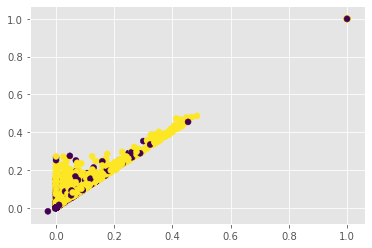

In [101]:
'''my_clf = MySGDClassifier(batch_generator, model_type='log_reg', alpha=0.05, batch_size=100)
my_clf.fit(X, y_train)
line1 = my_plot_decision_boundary(my_clf)
clf = SGDClassifier(loss='log').fit(X, y_train)
x = np.linspace(-50, 50)
k = ((clf.coef_[0][0]) * x)/(-clf.coef_[0][1])
line2, = plt.plot(x, k, '-r', label='sklearn')
plt.legend(handles=[line1, line2])'''
plt.scatter(X[:, 1], X[:, 2], c=y_train)
plt.show()

In [102]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

In [103]:
lg = LGBMClassifier()
X_tr, X_val, y, y_val = train_test_split(X,  y_train, random_state=34, test_size=0.33)

In [104]:
lg.fit(X_tr, y)
res = lg.predict(X_val)
print(f1_score(res, y_val))

0.6787695410993445


In [105]:
import lightgbm as lgbm

In [106]:
params = {
    'objective' :'binary',
    'learning_rate' : 0.02,
    'num_leaves' : 76,
    'feature_fraction': 0.64, 
    'bagging_fraction': 0.8, 
    'bagging_freq':1,
    'boosting_type' : 'gbdt',
    'metric': 'f1_score'
}
X_train, X_valid, Y_train, Y_valid = train_test_split(X,  y_train, random_state=34523, test_size=0.33)
    
    
d_train = lgbm.Dataset(X_train, Y_train)
d_valid = lgbm.Dataset(X_valid, Y_valid)

bst = lgbm.train(params, d_train, 5000, valid_sets=[d_valid], verbose_eval=50)
pred = bst.predict(X_test)

In [107]:
pred = [(i >= 0.5).astype(int) for i in pred]

In [94]:
lg = LGBMClassifier()
lg.fit(X, y_train)
res = lg.predict(X_test)
data = {'pair_id' : range(11691, 28318), 'target': res}
res = pd.DataFrame(data)
res.to_csv('sec_pred.csv', index=False)

In [108]:
data = {'pair_id' : range(11691, 28318), 'target': pred}
res = pd.DataFrame(data)
res.to_csv('sec_pred.csv', index=False)

In [32]:
from sklearn.metrics import f1_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

In [216]:
st = StandardScaler()
X = st.fit_transform(X_train, y_train)
print(X.shape)

(11690, 20)


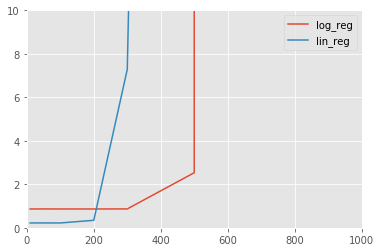

In [29]:
mas = [10, 50, 100, 200, 300, 500, 1000]
mas1 = []
mas2 = []
for i in mas:
    my_clf = MySGDClassifier(batch_generator,
                             model_type='log_reg',
                             batch_size=i).fit(X, y_train)
    mas1.append(my_clf.errors_log['loss'][-1])
    my_clf = MySGDClassifier(batch_generator,
                             model_type='lin_reg',
                             batch_size=i).fit(X, y_train)
    mas2.append(my_clf.errors_log['loss'][-1])
l1, = plt.plot(mas, mas1, label='log_reg')
l2, = plt.plot(mas, mas2, label='lin_reg')
plt.legend(handles=[l1, l2])
plt.xlim(0, 1000)
plt.ylim(0, 10)
plt.show()

Выберем batch_size = 100

Разбейте данные на обучение и валидацию. Подберите параметры C, alpha, max_epoch, model_type на валидации (Вы же помните, как правильно в этой задаче делать валидацию?)

In [109]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=3, shuffle=True)

c_range = [0.1, 1, 10, 30]
alpha_range = [0.01, 0.05, 0.15, 0.25]
max_epoch_range = [5, 10, 50]

best_set = {}
max_score = 0.0

for c in c_range:
    for alpha in alpha_range:
        for max_epoch in max_epoch_range:
            clf = MySGDClassifier(batch_generator,
                                  C=c,
                                  alpha=alpha,
                                  max_epoch=max_epoch,
                                  model_type='log_reg', batch_size=100)
            sp = kf.split(X)
            scores = []
            for train_ind, test_ind in sp:
                clf.fit(X[train_ind], y_train[train_ind])
                scores.append(f1_score(y_train[test_ind],
                                       clf.predict(X[test_ind])))
            u, counts = np.unique(clf.predict(X[test_ind]), return_counts=True)
            print(u, counts)
            score = np.mean(np.array(scores))
            if score > max_score:
                best_set = {'C': c, 'alpha': alpha,
                            'max_epoch': max_epoch, 'model_type': 'log_reg'}
                max_score = score
            print('''done for set {} {} {} 
            by log_reg, score = {}'''.format(c, alpha, max_epoch, score))
            clf = MySGDClassifier(batch_generator,
                                  C=c, alpha=alpha,
                                  max_epoch=max_epoch,
                                  model_type='lin_reg', batch_size=100)
            sp = kf.split(X)
            scores = []
            for train_ind, test_ind in sp:
                clf.fit(X[train_ind], y_train[train_ind])
                scores.append(f1_score(y_train[test_ind],
                                       (clf.predict(X[test_ind]) >= 0.5)
                                       .astype(int)))
            score = np.mean(np.array(scores))
            if score > max_score:
                best_set = {'C': c, 'alpha': alpha,
                            'max_epoch': max_epoch, 'model_type': 'lin_reg'}
                max_score = score
            print('''done for set {} {} {}
            by lin_reg, score = {}'''.format(c, alpha, max_epoch, score))
print(best_set)
print(max_score)

[0 1] [3873   23]
done for set 0.1 0.01 5 
            by log_reg, score = 0.04202410345641335


/Users/azelentsov/PycharmProjects/ml/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


done for set 0.1 0.01 5
            by lin_reg, score = 0.0
[0 1] [3871   25]
done for set 0.1 0.01 10 
            by log_reg, score = 0.04205632703780138
done for set 0.1 0.01 10
            by lin_reg, score = 0.0
[0 1] [3865   31]
done for set 0.1 0.01 50 
            by log_reg, score = 0.0418356604959933
done for set 0.1 0.01 50
            by lin_reg, score = 0.0
[0 1] [3873   23]
done for set 0.1 0.05 5 
            by log_reg, score = 0.04173366135295841
done for set 0.1 0.05 5
            by lin_reg, score = 0.0
[0] [3896]
done for set 0.1 0.05 10 
            by log_reg, score = 0.14722630501443226


KeyboardInterrupt: 

Подберите порог линейной модели, по достижении которого, Вы будете относить объект к классу 1. Вспомните, какую метрику мы оптимизируем в соревновании.  Как тогда правильно подобрать порог?

In [219]:
mas = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
max_score = 0.0
best_border = 0.0
for i in mas:
    clf = MySGDClassifier(batch_generator, C=10, alpha=0.05, max_epoch=5,
                          model_type='log_reg', batch_size=100, border=i)
    sp = kf.split(X)
    scores = []
    for train_ind, test_ind in sp:
        clf.fit(X[train_ind], y_train[train_ind])
        scores.append(f1_score(y_train[test_ind],
                               (clf.predict(X[test_ind]) >= 0.5).astype(int)))
    score = np.mean(np.array(scores))
    if score > max_score:
        max_score = score
        best_border = i
    print('done for border {}, score = {}'.format(i, score))
print(max_score)
print(best_border)

done for border 0.1, score = 0.6827312833502694
done for border 0.2, score = 0.6833610697672468
done for border 0.3, score = 0.6800154676110456
done for border 0.4, score = 0.6785568243468805
done for border 0.5, score = 0.6764386056986532
done for border 0.6, score = 0.6743870721863855
done for border 0.7, score = 0.6691551760512184
done for border 0.8, score = 0.6642737357617975
done for border 0.9, score = 0.6548894828023982
0.6833610697672468
0.2


In [95]:
clf = SGDClassifier()
param_grid = {
    'loss' :['log', 'hinge', 'perceptron'],
    'penalty' : ['l1', 'l2', 'elasticnet'],
    'alpha' : [10 ** x for x in range(-6, 1)],
    'l1_ratio' : [0, 0.1, 0.2, 0.5, 0.8, 0.9, 1]
}
grid = GridSearchCV(estimator = clf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)
grid.fit(X, y_train)
grid.cv_results_['mean_test_score']

Fitting 3 folds for each of 441 candidates, totalling 1323 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 1188 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 1323 out of 1323 | elapsed:   10.2s finished


array([0.82780154, 0.83079555, 0.8239521 , 0.82489307, 0.81043627,
       0.82763045, 0.81000855, 0.82617622, 0.79161677, 0.827716  ,
       0.82634731, 0.82540633, 0.83336185, 0.82275449, 0.63892216,
       0.62840034, 0.82720274, 0.83088109, 0.82532079, 0.80573139,
       0.82848589, 0.82549187, 0.61967494, 0.83507271, 0.7988024 ,
       0.78947819, 0.65226689, 0.82001711, 0.81582549, 0.8332763 ,
       0.64568007, 0.82566296, 0.81351583, 0.78605646, 0.61017964,
       0.64311377, 0.83130881, 0.83473054, 0.8100941 , 0.82489307,
       0.81531223, 0.83182207, 0.79811805, 0.58716852, 0.64234388,
       0.83105218, 0.8245509 , 0.80966638, 0.8251497 , 0.47382378,
       0.8251497 , 0.77331052, 0.82463644, 0.47313944, 0.83430282,
       0.64901625, 0.83224979, 0.77279726, 0.45115483, 0.83250642,
       0.81950385, 0.83036784, 0.8219846 , 0.82840034, 0.82318221,
       0.82232678, 0.82822926, 0.83361848, 0.82822926, 0.8314799 ,
       0.7497006 , 0.78152267, 0.82968349, 0.82181352, 0.80906

In [96]:
grid.best_params_

{'alpha': 0.001, 'l1_ratio': 0.9, 'loss': 'hinge', 'penalty': 'elasticnet'}

In [97]:
np.max(grid.cv_results_['mean_test_score'])

0.8354148845166809

In [26]:
arg = np.array(grid.cv_results_['mean_test_score']).argsort()
best5 = np.array(grid.cv_results_['params'])[arg][:5]
best5

array([{'alpha': 1e-05, 'l1_ratio': 0.2, 'loss': 'perceptron', 'penalty': 'elasticnet'},
       {'alpha': 1, 'l1_ratio': 0.9, 'loss': 'perceptron', 'penalty': 'elasticnet'},
       {'alpha': 0.001, 'l1_ratio': 0.9, 'loss': 'perceptron', 'penalty': 'elasticnet'},
       {'alpha': 0.001, 'l1_ratio': 0.2, 'loss': 'perceptron', 'penalty': 'l2'},
       {'alpha': 0.01, 'l1_ratio': 0.9, 'loss': 'perceptron', 'penalty': 'l2'}],
      dtype=object)

In [98]:
clf = SGDClassifier(alpha=0.001, l1_ratio=0.9, loss='hinge', penalty='elasticnet')
clf.fit(X, y_train)


y = (clf.predict(X_test) >= 0.5).astype(int)

In [91]:
import pandas as pd
test_data = pd.read_csv('../project/anomaly-detection-competition-ml1-ts-fall-2019/test_groups.csv')
testgroups_titledata = {}
for i in range(len(test_data)):
    new_doc = test_data.iloc[i]
    doc_group = new_doc['group_id']
    doc_id = new_doc['doc_id']
    title = doc_to_title[doc_id]
    text = doc_texts[doc_texts.doc_id == doc_id].iloc[0]['target']
    if doc_group not in testgroups_titledata:
        testgroups_titledata[doc_group] = []
    testgroups_titledata[doc_group].append((doc_id, 4*(title + ' ') + text))

In [93]:
import numpy as np
#X_test = []
X_test = np.array([])
groups_test = []
for new_group in testgroups_titledata:
    docs = testgroups_titledata[new_group]
    texts = [doc[1] for doc in docs]
    dictionary = corpora.Dictionary(text.split() for text in texts)
    
    corpus = [ dictionary.doc2bow(text.split()) for text in texts]
    
    lsi_model = LsiModel(corpus=corpus, id2word=dictionary)
    
    dist = similarities.MatrixSimilarity(lsi_model[corpus])
    
    dist = np.sort(dist, axis=1)
    dist = dist[:, 1:N_FEATURES+1]
    if X_test.shape[0] == 0:
        X_test = dist
    else:
        X_test = np.vstack((X_test, dist))
    
    for k, (doc_id, title) in enumerate(docs):
        groups_test.append(new_group)
        '''all_dist = []
        words = set(title.strip().split())
        for j in range(0, len(docs)):
            if k == j:
                continue
            doc_id_j, title_j = docs[j]
            words_j = set(title_j.strip().split())
            all_dist.append(len(words.intersection(words_j)))
        X_test.append(sorted(all_dist, reverse=True)[0:N_FEATURES])'''
#X_test = np.array(X_test)
groups_test = np.array(groups_test)
print(X_test.shape, groups_test.shape)
print(groups_test)

(16627, 20) (16627,)
[130 130 130 ... 309 309 309]


In [99]:
clf = SGDClassifier(alpha=0.001, l1_ratio=0.9, loss='hinge', penalty='elasticnet')
clf.fit(X, y_train)


y = (clf.predict(X_test) >= 0.5).astype(int)
u, counts = np.unique(y, return_counts=True)
print(counts)
r = range(11691, 28318)
print(len(r))

[13621  3006]
16627


In [100]:
data = {'pair_id' : range(11691, 28318), 'target': y}
res = pd.DataFrame(data)
res.to_csv('sec_pred.csv', index=False)